# L3: Topic Models
### 732A92/TDDE16 Text Mining
Måns Magnusson

The purpose of this lab is to implement the standard Gibbs sampling algorithm for Latent Dirichlet Allocation in Python. You will be supplied starter code, a smaller corpus with State of the Union addresses for the period 1975 to 2000 by paragraph and a list with English stop words. The code is implemented as a class, `LDAGibbs`, where you are expected to replace central parts of the code with your own implementations.

### 1. Sampling

Implement the basic collapsed Gibbs sampling algorithm for Latent Dirichlet Allocation. Use the starter code and add the components that is missing (the sampler part). We use the fact that 

$$p(z_{i}=k)\propto\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\sum^{V}\left(\beta+n_{k,w_{i}}^{(w)}\right)}=\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{V\beta+n_{k}}$$

to simplify computations, where $K$ is the number of topics, $V$ is the vocabulary size and $D$ is the number of documents. $\mathbf{n}^{(d)}$ is a count matrix of size $D\times K$ with the number of topic indicators by document, $d$, and topic $k$, $\mathbf{n}^{(w)}$ is a count matrix of size $K\times V$ with the number of topic indicators by topic, $k$, and word type, $w$. $\mathbf{n}$ is a topic indicator count vector of length $K$ that contain the number of topic indicators in each topic. The detailed algorithm can be found below:

__Data:__ tokenized corpus $\mathbf{w}$, priors $\alpha, \beta$ <br>
__Result:__ topic indicators $\mathbf{z}$

Init topic indicators $\mathbf{z}$ randomly per token<br>
Init topic probability vector $\mathbf{p}$<br>
Init $\mathbf{n}^{w}$, the topic type count matrix of size ($K \times V$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}^{d}$, the document topic count matrix of size ($D \times K$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}$, the topic count vector of length ($K$) with respect to $\mathbf{z}$<br>

for $g \leftarrow 1$ __to__ _num_\__iterations_ __do__<br>
&emsp;&emsp;// Iterate over all tokens<br>
&emsp;&emsp;for $i \leftarrow 1$ __to__ $N$ __do__<br>
&emsp;&emsp;&emsp;&emsp;// Remove current topic indicator $z_i$ from $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ -= 1, $n^{(d)}_{d_i,z_i}$ -= 1, $n_{z_i}$ -= 1<br>
&emsp;&emsp;&emsp;&emsp;for $k \leftarrow 1$ __to__ $K$ __do__<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;// Compute the unnormalized probability of each topic indicator<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\mathbf{p}_k \leftarrow \left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\left(V\beta+n_{k}\right)}$<br>
&emsp;&emsp;&emsp;&emsp;__end__<br>
&emsp;&emsp;&emsp;&emsp;// Sample the topic indicator<br>
&emsp;&emsp;&emsp;&emsp;$z_i \leftarrow $ Categorical($\mathbf{p}$)<br>
&emsp;&emsp;&emsp;&emsp;// Add the new topic indicator $z_i$ to $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ += 1, $n^{(d)}_{d_i,z_i}$ += 1, $n_{z_i}$ += 1<br>
&emsp;&emsp;__end__<br>
__end__

For a complete derivation of the collapsed Gibbs sampler for LDA, see https://lingpipe.files.wordpress.com/2010/07/lda3.pdf.

Personal notes:


$\alpha$ and $\beta$ are the parameters to the Dirichlet. 

$\alpha$ is the prior on the document level of the topic distributions, where a high $\alpha$ indicates that the document will contain most of the topics, not just one or two in particular. Conversely, a low $\alpha$ means it will probably contain just a few of the topics.

$\beta$ is the prior on the per-topic word distributions. A high $\beta$ means that a topic will contain a mixture of most of the words. A large $\beta$ says it may just contain a few of the words.

$\theta_m$ is the topic distribution for document m.

In [1]:
import numpy
import random, scipy.special
from tm3 import LDAGibbs
import matplotlib.pyplot as plt

class MyGibbs(LDAGibbs):
        
    def __init__(self, num_topics, docs_file_name, stop_list_file_name = None):
        self.num_topics = num_topics
        self.num_docs = 0
        self.docs = []
        ## Prepare set of stop words
        self.stop_words = set()
        if stop_list_file_name != None:
            with open(stop_list_file_name) as f:
                for line in f:
                    word = line.rstrip()
                    self.stop_words.add(word)
        self.read_documents(docs_file_name)
        self.initialize_matrices()
            
    def read_documents(self, filename):
        """Reads documents from a file, filters stop words and initializes
        the vocabulary. Also converts tokens to integer term IDs."""
        self.vocab = []
        self.vocab_ids = {}
        with open(filename) as f:
            for line in f:
                line = line.replace(".", " ").replace(",", " ").lower()
                self.num_docs += 1
                tokens = []
                for w in line.split():
                    if not w in self.stop_words:
                        if w in self.vocab_ids:
                            tokens.append(self.vocab_ids[w])
                        else:
                            term_id = len(self.vocab)
                            self.vocab.append(w)
                            self.vocab_ids[w] = term_id
                            tokens.append(term_id)
                self.docs.append({ 'tokens': tokens })
        self.num_terms = len(self.vocab)
        print("Read {} documents with a total of {} terms".format(self.num_docs, self.num_terms))
        
    def initialize_matrices(self):
        """Initializes numpy arrays for the matrix computations performed
        by the sampler during the MCMC process."""
        ## Set up numpy matrices
        self.term_topics = numpy.zeros((self.num_terms, self.num_topics)) # n^w
        self.doc_topics = numpy.zeros((self.num_docs, self.num_topics)) # n^d
        self.topic_totals = numpy.zeros(self.num_topics) # n
        self.doc_totals = numpy.zeros(self.num_docs)
        ## Initialize topics randomly
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            ## Create an array of random topic assignments
            doc['topics'] = [random.randrange(self.num_topics) for token in doc['tokens']]
            ## Construct the initial summary statistics
            doc_length = len(doc['tokens'])
            for token, topic in zip(doc['tokens'], doc['topics']):
                self.term_topics[token][topic] += 1 # n_wk
                self.doc_topics[doc_id][topic] += 1 # n_dk
                self.topic_totals[topic] += 1       # n_k
                self.doc_totals[doc_id] += 1
        ## Printout to check that everything is coherent
        #print(sum(sum(self.doc_topics)))
        #print(sum(sum(self.term_topics)))
        #print(sum(self.topic_totals))
        #print(sum(self.doc_totals))
        
    def run(self, num_iterations = 50, alpha = 0.1, beta = 0.01):
        self.logprobs = []
        for iteration in range(num_iterations): #iteration = 0
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs.append(logprob)
            if iteration % 10 == 0:
                print("iteration {}, {}".format(iteration, logprob))
            
    def make_draw(self, alpha, beta):
        self.total_tokens = 0 # some bug in the package requires this
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            for i, (token, topic) in enumerate(zip(doc['tokens'], doc['topics'])):
                # remove token / update matrices
                self.term_topics[token][topic] -= 1 # n_wk
                self.doc_topics[doc_id][topic] -= 1 # n_dk
                self.topic_totals[topic] -= 1       # n_k
      
                a = (alpha + self.doc_topics[doc_id]) * (beta + self.term_topics[token])
                b = self.topic_totals * beta + self.topic_totals
                probs = a / b
                probs = probs / probs.sum()

                # draw samples from multionomial with probabilities in probs
                sample = numpy.random.multinomial(1, probs)
                new_topic = numpy.argwhere(sample == 1).flatten()[0]

                # set this tokens topic to the new topic
                doc['topics'][i] = new_topic
                
                # update matrices with new topic as well
                self.term_topics[token][new_topic] += 1 # n_wk
                self.doc_topics[doc_id][new_topic] += 1 # n_dk
                self.topic_totals[new_topic] += 1       # n_k
                
                self.total_tokens += 1
            
            
    def print_topics(self, j):
        for k in range(self.num_topics):
            indexes = numpy.argsort(self.term_topics[:, k])[-j:]
            print("TOPIC: {}".format(k))
            for i in indexes[::-1]:
                print("{} [{}]".format(self.vocab[i], self.term_topics[i, k]), end=" ")
            print("\n")
        #super().print_topics(j)
    
    def plot(self):
        plt.plot(self.logprobs)          
    
    def compute_logprob(self, alpha, beta):
        ## TODO: implement this function for the bonus exercise
        return super().compute_logprob(alpha, beta)

        

Implement the `make_draw` function above. You should get behavior very similar to the results from calling the parent class.

In [3]:
num_topics = 10
num_iterations = 201

model = MyGibbs(num_topics, 'sotu_1975_2000.txt', 'stoplist_en.txt')
model.run(num_iterations)

Read 2898 documents with a total of 8695 terms
iteration 0, -10.369810768943793
iteration 10, -8.948038711358514
iteration 20, -8.720611252969338
iteration 30, -8.613066223755386
iteration 40, -8.540815039373204
iteration 50, -8.499504042518573
iteration 60, -8.453617879119196
iteration 70, -8.429401697811471
iteration 80, -8.410562133698399
iteration 90, -8.398674307704727
iteration 100, -8.382665823945965
iteration 110, -8.368049151991238
iteration 120, -8.366697836192907
iteration 130, -8.353929340695366
iteration 140, -8.346962326664816
iteration 150, -8.348575342900554
iteration 160, -8.345620784061039
iteration 170, -8.341982118909769
iteration 180, -8.333920191204058
iteration 190, -8.328590269996653
iteration 200, -8.325706333147432


### 2. Top terms
Implement the `print_topics` function to extract the top `j` largest counts in $n(w)$ by row. This is the most probable word types in each topic.

In [4]:
model.print_topics(10)

TOPIC: 0
crime [98.0] environment [52.0] space [52.0] technology [49.0] science [45.0] drugs [45.0] research [41.0] community [40.0] national [37.0] drug [36.0] 

TOPIC: 1
soviet [153.0] nuclear [142.0] forces [106.0] military [100.0] defense [83.0] president [79.0] strategic [66.0] war [66.0] congress [66.0] arms [63.0] 

TOPIC: 2
health [199.0] care [176.0] children [142.0] people [133.0] families [113.0] year [112.0] family [103.0] americans [99.0] congress [88.0] child [84.0] 

TOPIC: 3
people [194.0] work [160.0] welfare [132.0] children [116.0] make [105.0] schools [96.0] education [94.0] give [86.0] government [86.0] good [77.0] 

TOPIC: 4
america [331.0] people [205.0] world [157.0] nation [157.0] tonight [130.0] american [128.0] americans [123.0] time [116.0] years [112.0] freedom [109.0] 

TOPIC: 5
congress [162.0] government [158.0] federal [150.0] administration [147.0] programs [125.0] program [117.0] energy [111.0] act [87.0] policy [81.0] major [80.0] 

TOPIC: 6
world [2

### 3. Explore the data

Run your implemention on the State of the Union corpus until convergence with 10 topics, don't forget to remove stop words. Plot the log marginal posterior by the number of iterations. How many iterations do you need until convergence? How do you interpret the topics?

[Hint: You can use the plot-function to print the marginal probability for each iteration. To get it working in Jupyter you need to run the command `%matplotlib inline` before plotting the first time.]

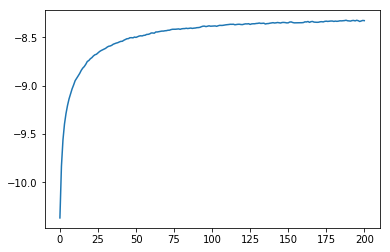

In [6]:
%matplotlib inline
model.plot()

#### Answer here:
It seems like it statrts to converge at around 170 iterations.

### 4. Simulate a new State of the Union speech

Write a function `new_speech` using the `MyGibbs` class to use the estimated values for $\Phi$ from your model (with stop words removed) to simulate a new State of the Union speech. Start out by simulating $\theta_d \sim Dir(\alpha = 0.5)$ and then simulate your document. Does it make sense? Why, why not?

In [36]:
def new_speech(model, alpha, num_words):
    speech = []
    topic_word_dist = dict()
    
    # get the word frequencies per topic from our model
    for k in range(model.num_topics):
        topic_word_dist[k] = model.term_topics[:,k] / model.term_topics[:,k].sum()
    
    # get a distribution over our topics for the document
    document_topic_dist = numpy.random.dirichlet([alpha for _ in range(model.num_topics)])

    #keep generating num_words times:
    for i in range(num_words):
            #draw topic from topic distribution
            topic_sample = numpy.random.multinomial(1, document_topic_dist)
            generated_topic = numpy.argwhere(topic_sample == 1).flatten()[0]
            
            #draw word from topic distribution
            word_sample = numpy.random.multinomial(1, topic_word_dist[generated_topic])
            generated_word_id = numpy.argwhere(word_sample == 1).flatten()[0]
            
            # reverse lookup word from index
            generated_word = model.vocab[generated_word_id]
            speech.append(generated_word)
            
    return " ".join(speech)

In [37]:
new_speech(model, 0.5, 100)

'time deficit bay environmental meet country $150 work encourage welfare contribution violations barely assure utilize continued reach higher 21st total mob world retirement congress commitment due area liberty solving restrained missions february 59 transportation micronesia confidence provided national functions aggressive increase federal policy authority states country 000 terminal days park national 1980 capability attention leadership citizens transferred national mutual threat acid president created 000 provided government determine warning citizens effective problem cities 1979 propose strong restrain noted provide important development projects cut point executive services broader thing jones designation support legally year providing bring food energy state statutory space soul'

#### Answer here:
We think it does not make sense to use a fixed alpha which does not correspond to the alpha that was used to sample within the gibbs sampling process. A different alpha will generate a different topic distribution for the documents. 
It would be better to just draw from a multinomial described by the alpha values estimated in the sampling process.

### Bonus assignment:

To get better understanding how to implement the underlying model or similar models, you might want to implement your own function to compute the log marginal posterior. If so, implement the `compute_logprob` function.

$$\begin{align}
\log p(\mathbf{z}|\mathbf{w}) =& \log\prod^{K}p(\mathbf{w}|\mathbf{z},\beta)\prod^{D}p(\mathbf{z}|\alpha) \\
=& \sum^{K}\log\left[\frac{\Gamma\left(\sum^{V}\beta\right)}{\prod^{V}\Gamma\left(\beta\right)}\frac{\prod^{V}\Gamma\left(n_{kv}^{(w)}+\beta\right)}{\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)}\right]+\sum^{D}\log\left[\frac{\Gamma\left(\sum^{K}\alpha\right)}{\prod^{K}\Gamma\left(\alpha\right)}\frac{\prod^{K}\Gamma\left(n_{dk}^{(d)}+\alpha\right)}{\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)}\right] \\
=& K\log\Gamma\left(V\beta\right)-KV\log\Gamma\left(\beta\right)+\sum^{K}\sum^{V}\log\Gamma\left(n_{kv}^{(w)}+\beta\right)-\sum^{K}\log\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)\\
&+ D\log\Gamma\left(K\alpha\right)-DK\log\Gamma\left(\alpha\right)+\sum^{D}\sum^{K}\log\Gamma\left(n_{dk}^{(d)}+\alpha\right)-\sum^{D}\log\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)
\end{align}$$

In Python, use `scipy.special.gammaln` for $\log\Gamma(x)$ (if you run into problems, you might try `math.lgamma` instead).